KLMS vs OMP Comparison

Case 1: Non-Sparse Data Analysis
Generated non-sparse dataset: (1000, 100)
Target statistics - Mean: 0.0472, Std: 5.4610
KLMS Final MSE: 35.196510
OMP Final MSE: 0.000000

Case 2: Sparse Data Analysis
True sparsity level: 10 non-zero coefficients
Target statistics - Mean: 0.1081, Std: 2.9425
KLMS Final MSE: 13.851871
OMP Final MSE: 0.000000


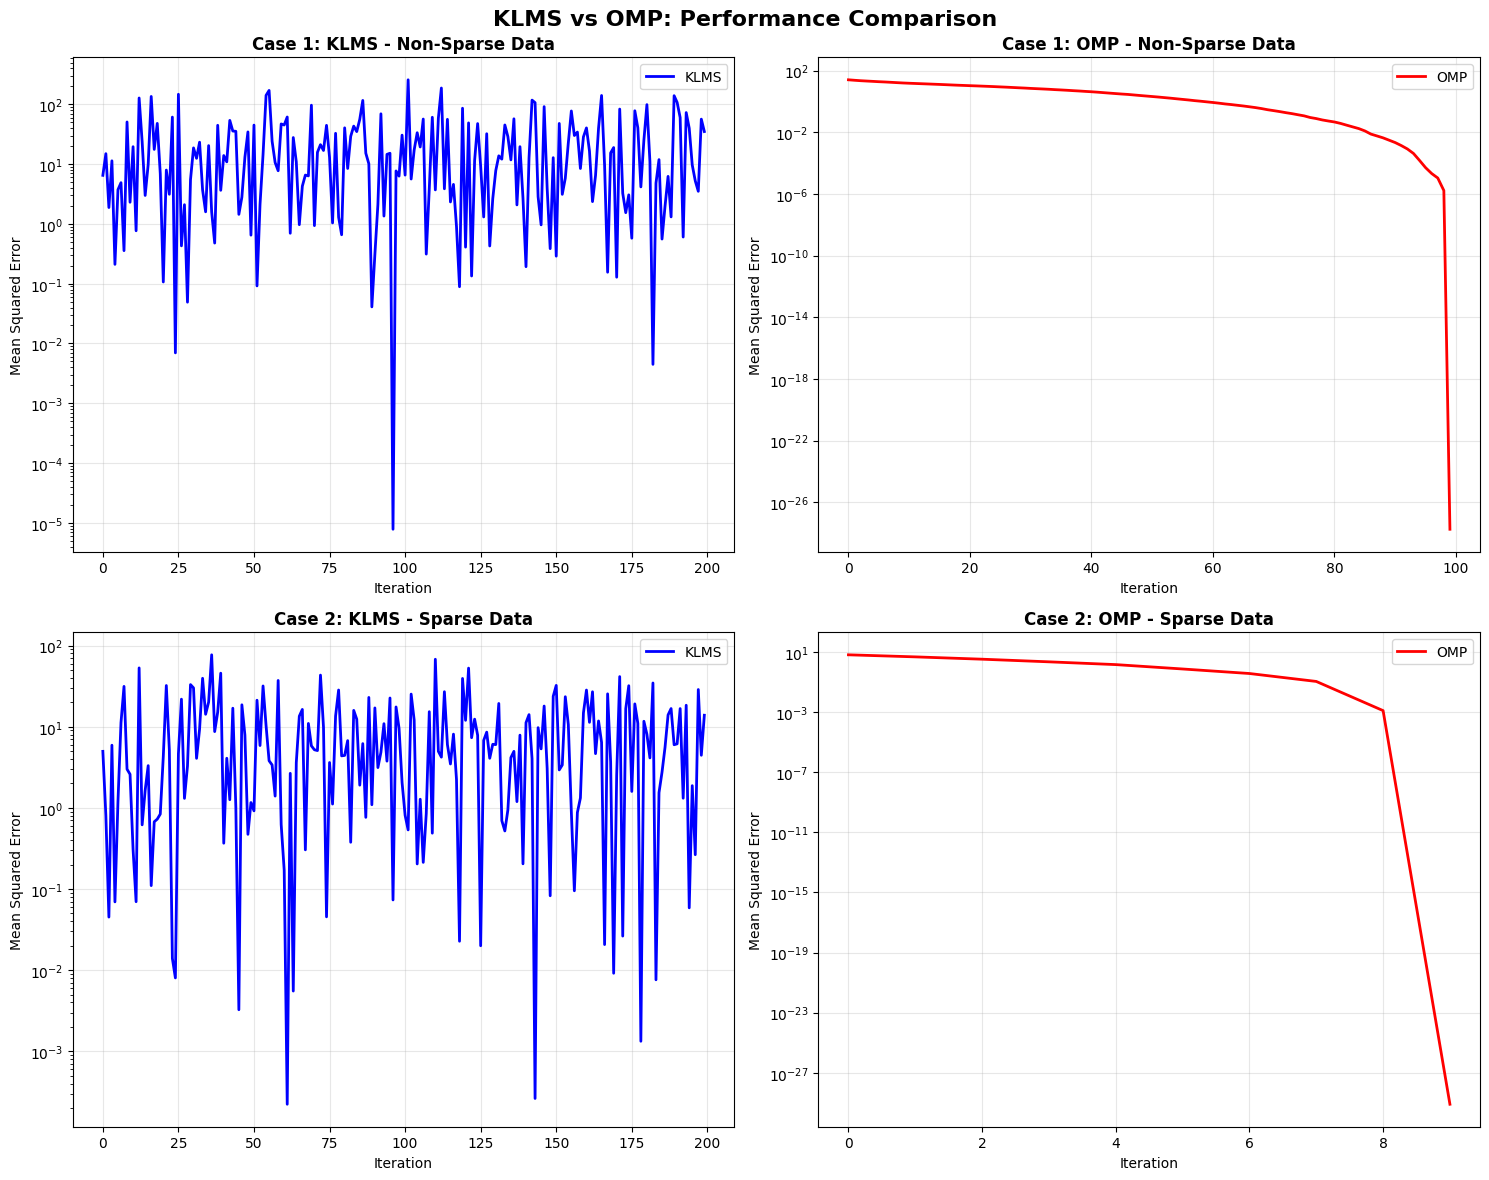

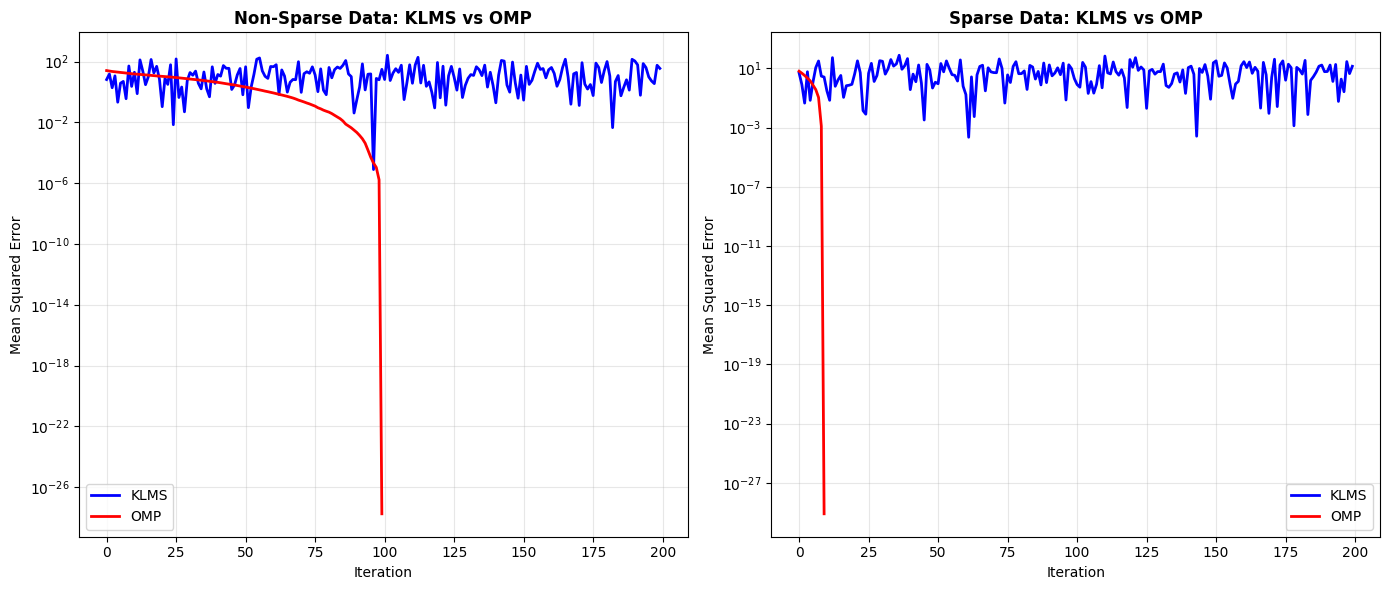


Non-Sparse Data Results:
  KLMS Final MSE: 35.19650953
  OMP Final MSE:  0.00000000
   OMP performs better for non-sparse data

Sparse Data Results:
  KLMS Final MSE: 13.85187084
  OMP Final MSE:  0.00000000
   OMP performs better for sparse data

OVERALL RECOMMENDATION:
  • For Non-Sparse Data: Use OMP
  • For Sparse Data: Use OMP


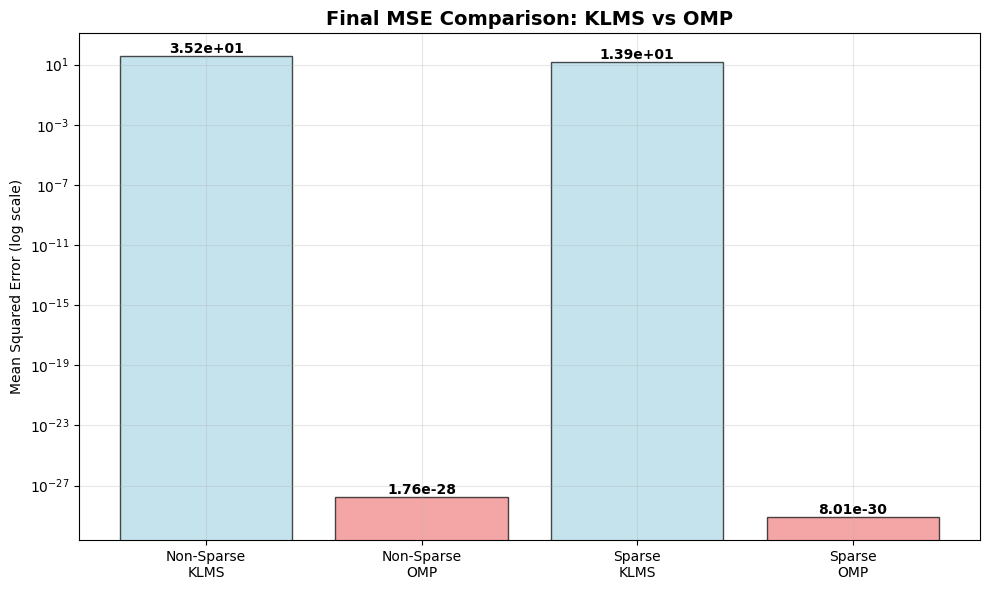

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

class KLMSAlgorithm:
    
    def __init__(self, learning_rate=0.1, kernel_type='gaussian', kernel_param=1.0):
        self.learning_rate = learning_rate
        self.kernel_type = kernel_type
        self.kernel_param = kernel_param
        self.dictionary = []
        self.coefficients = []
        self.mse_history = []
        
    def gaussian_kernel(self, x1, x2):
        return np.exp(-np.linalg.norm(x1 - x2)**2 / (2 * self.kernel_param**2))
    
    def predict(self, x):
        if len(self.dictionary) == 0:
            return 0
        
        prediction = 0
        for i, dict_elem in enumerate(self.dictionary):
            prediction += self.coefficients[i] * self.gaussian_kernel(x, dict_elem)
        return prediction
    
    def update(self, x, y):
        prediction = self.predict(x)
        error = y - prediction
        
        self.dictionary.append(x.copy())
        self.coefficients.append(self.learning_rate * error)
        
        return error**2
    
    def fit(self, X, y, max_iterations=None):
       
        if max_iterations is None:
            max_iterations = len(X)
            
        self.dictionary = []
        self.coefficients = []
        self.mse_history = []
        
        for i in range(min(max_iterations, len(X))):
            mse = self.update(X[i], y[i])
            self.mse_history.append(mse)
            
        return self.mse_history

class OMPAlgorithm:
    
    def __init__(self, sparsity_level=None, tolerance=1e-6):
        self.sparsity_level = sparsity_level
        self.tolerance = tolerance
        self.mse_history = []
        self.coefficients = None
    def fit(self, A, y, max_iterations=None):
        n_features = A.shape[1]
        
        if self.sparsity_level is None:
            self.sparsity_level = min(n_features, len(y) // 4)
            
        if max_iterations is None:
            max_iterations = min(self.sparsity_level, n_features)
            
        residual = y.copy()
        selected_atoms = []
        self.mse_history = []
        
        for iteration in range(max_iterations):
            
            correlations = np.abs(A.T @ residual)
            
            
            for idx in selected_atoms:
                correlations[idx] = 0
            
            best_atom = np.argmax(correlations)
            selected_atoms.append(best_atom)
            
            A_selected = A[:, selected_atoms]
            try:
                coeffs = np.linalg.lstsq(A_selected, y, rcond=None)[0]
                prediction = A_selected @ coeffs
                residual = y - prediction
            except np.linalg.LinAlgError:
                break
            
            mse = np.mean(residual**2)
            self.mse_history.append(mse)
            
            if mse < self.tolerance:
                break
                
        # Store final coefficients
        self.coefficients = np.zeros(n_features)
        if len(selected_atoms) > 0:
            self.coefficients[selected_atoms] = coeffs
            
        return self.mse_history
    
    def predict(self, A):
    
        if self.coefficients is None:
            return np.zeros(A.shape[0])
        return A @ self.coefficients

class DatasetGenerator:
    
    @staticmethod
    def generate_regression_data(n_samples=1000, n_features=100, noise_level=0.0, 
                               mean=0, variance=1.2, sparse=False, sparsity_ratio=0.1):

        np.random.seed(42)  
        
        H = np.random.normal(mean, np.sqrt(variance), (n_samples, n_features))
        
        if sparse:

            true_coeffs = np.zeros(n_features)
            sparse_indices = np.random.choice(n_features, 
                                            int(n_features * sparsity_ratio), 
                                            replace=False)
            true_coeffs[sparse_indices] = np.random.normal(0, 1, len(sparse_indices))
        else:
    
            true_coeffs = np.random.normal(0, 0.5, n_features)
        
        
        y = H @ true_coeffs
        
        
        if noise_level > 0:
            noise = np.random.normal(0, noise_level, n_samples)
            y += noise
            
        return H, y, true_coeffs

def run_comparison():
    
    print("KLMS vs OMP Comparison")
   
    
    n_samples = 1000
    n_features = 100
    mean = 0
    variance = 1.2
    max_iterations = 200
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('KLMS vs OMP: Performance Comparison', fontsize=16, fontweight='bold')
    
    results = {}
    
    print("\nCase 1: Non-Sparse Data Analysis")
    
    
    X_nonsparse, y_nonsparse, true_coeffs_nonsparse = DatasetGenerator.generate_regression_data(
        n_samples=n_samples, n_features=n_features, mean=mean, variance=variance, sparse=False
    )
    
    print(f"Generated non-sparse dataset: {X_nonsparse.shape}")
    print(f"Target statistics - Mean: {np.mean(y_nonsparse):.4f}, Std: {np.std(y_nonsparse):.4f}")
    
    klms_nonsparse = KLMSAlgorithm(learning_rate=0.01, kernel_param=1.0)
    klms_mse_nonsparse = klms_nonsparse.fit(X_nonsparse, y_nonsparse, max_iterations)
    
 
    omp_nonsparse = OMPAlgorithm(sparsity_level=20)
    omp_mse_nonsparse = omp_nonsparse.fit(X_nonsparse, y_nonsparse, max_iterations)
    

    axes[0, 0].plot(klms_mse_nonsparse, 'b-', label='KLMS', linewidth=2)
    axes[0, 0].set_title('Case 1: KLMS - Non-Sparse Data', fontweight='bold')
    axes[0, 0].set_xlabel('Iteration')
    axes[0, 0].set_ylabel('Mean Squared Error')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    axes[0, 0].set_yscale('log')
    
    axes[0, 1].plot(omp_mse_nonsparse, 'r-', label='OMP', linewidth=2)
    axes[0, 1].set_title('Case 1: OMP - Non-Sparse Data', fontweight='bold')
    axes[0, 1].set_xlabel('Iteration')
    axes[0, 1].set_ylabel('Mean Squared Error')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].legend()
    axes[0, 1].set_yscale('log')
    
    
    results['nonsparse'] = {
        'klms_final_mse': klms_mse_nonsparse[-1] if klms_mse_nonsparse else float('inf'),
        'omp_final_mse': omp_mse_nonsparse[-1] if omp_mse_nonsparse else float('inf'),
        'klms_iterations': len(klms_mse_nonsparse),
        'omp_iterations': len(omp_mse_nonsparse)
    }
    
    print(f"KLMS Final MSE: {results['nonsparse']['klms_final_mse']:.6f}")
    print(f"OMP Final MSE: {results['nonsparse']['omp_final_mse']:.6f}")
    
    print("\nCase 2: Sparse Data Analysis")
    
    
    X_sparse, y_sparse, true_coeffs_sparse = DatasetGenerator.generate_regression_data(
        n_samples=n_samples, n_features=n_features, mean=mean, variance=variance, 
        sparse=True, sparsity_ratio=0.1
    )
    
    
    print(f"True sparsity level: {np.sum(true_coeffs_sparse != 0)} non-zero coefficients")
    print(f"Target statistics - Mean: {np.mean(y_sparse):.4f}, Std: {np.std(y_sparse):.4f}")
    
   
    klms_sparse = KLMSAlgorithm(learning_rate=0.01, kernel_param=1.0)
    klms_mse_sparse = klms_sparse.fit(X_sparse, y_sparse, max_iterations)
    
    omp_sparse = OMPAlgorithm(sparsity_level=15)
    omp_mse_sparse = omp_sparse.fit(X_sparse, y_sparse, max_iterations)
    
    
    axes[1, 0].plot(klms_mse_sparse, 'b-', label='KLMS', linewidth=2)
    axes[1, 0].set_title('Case 2: KLMS - Sparse Data', fontweight='bold')
    axes[1, 0].set_xlabel('Iteration')
    axes[1, 0].set_ylabel('Mean Squared Error')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend()
    axes[1, 0].set_yscale('log')
    
    axes[1, 1].plot(omp_mse_sparse, 'r-', label='OMP', linewidth=2)
    axes[1, 1].set_title('Case 2: OMP - Sparse Data', fontweight='bold')
    axes[1, 1].set_xlabel('Iteration')
    axes[1, 1].set_ylabel('Mean Squared Error')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()
    axes[1, 1].set_yscale('log')
    
   
    results['sparse'] = {
        'klms_final_mse': klms_mse_sparse[-1] if klms_mse_sparse else float('inf'),
        'omp_final_mse': omp_mse_sparse[-1] if omp_mse_sparse else float('inf'),
        'klms_iterations': len(klms_mse_sparse),
        'omp_iterations': len(omp_mse_sparse)
    }
    
    print(f"KLMS Final MSE: {results['sparse']['klms_final_mse']:.6f}")
    print(f"OMP Final MSE: {results['sparse']['omp_final_mse']:.6f}")
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(klms_mse_nonsparse, 'b-', label='KLMS', linewidth=2)
    plt.plot(omp_mse_nonsparse, 'r-', label='OMP', linewidth=2)
    plt.title('Non-Sparse Data: KLMS vs OMP', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.subplot(1, 2, 2)
    plt.plot(klms_mse_sparse, 'b-', label='KLMS', linewidth=2)
    plt.plot(omp_mse_sparse, 'r-', label='OMP', linewidth=2)
    plt.title('Sparse Data: KLMS vs OMP', fontweight='bold')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()
    
   
    
    
    print("\nNon-Sparse Data Results:")
    print(f"  KLMS Final MSE: {results['nonsparse']['klms_final_mse']:.8f}")
    print(f"  OMP Final MSE:  {results['nonsparse']['omp_final_mse']:.8f}")
    
    if results['nonsparse']['klms_final_mse'] < results['nonsparse']['omp_final_mse']:
        print("   KLMS performs better for non-sparse data")
        nonsparse_winner = "KLMS"
    else:
        print("   OMP performs better for non-sparse data")
        nonsparse_winner = "OMP"
    
    print("\nSparse Data Results:")
    print(f"  KLMS Final MSE: {results['sparse']['klms_final_mse']:.8f}")
    print(f"  OMP Final MSE:  {results['sparse']['omp_final_mse']:.8f}")
    
    if results['sparse']['klms_final_mse'] < results['sparse']['omp_final_mse']:
        print("   KLMS performs better for sparse data")
        sparse_winner = "KLMS"
    else:
        print("   OMP performs better for sparse data")
        sparse_winner = "OMP"
    
    print(f"\nOVERALL RECOMMENDATION:")
    print(f"  • For Non-Sparse Data: Use {nonsparse_winner}")
    print(f"  • For Sparse Data: Use {sparse_winner}")
    
    
    plt.figure(figsize=(10, 6))
    categories = ['Non-Sparse\nKLMS', 'Non-Sparse\nOMP', 'Sparse\nKLMS', 'Sparse\nOMP']
    mse_values = [
        results['nonsparse']['klms_final_mse'],
        results['nonsparse']['omp_final_mse'],
        results['sparse']['klms_final_mse'],
        results['sparse']['omp_final_mse']
    ]
    colors = ['lightblue', 'lightcoral', 'lightblue', 'lightcoral']
    
    bars = plt.bar(categories, mse_values, color=colors, alpha=0.7, edgecolor='black')
    plt.title('Final MSE Comparison: KLMS vs OMP', fontweight='bold', fontsize=14)
    plt.ylabel('Mean Squared Error (log scale)')
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    
    
    for bar, value in zip(bars, mse_values):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
                f'{value:.2e}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    return results

if __name__ == "__main__":
    results = run_comparison()